In [43]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

import torch 
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from transformer_encoder_decoder_qr_multivariate_model import TransformerEncoderDecoderQRMultiVariateModel

from utils import *

import random 
import os
import sys 
import copy 

In [44]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: NVIDIA GeForce RTX 3050 Laptop GPU


In [45]:
nhead =  8      # number of heads in the multi-head attention models
d_model = 32   # model dimension
d_hid = 64     # dimension of the feedforward network model
nlayers = 2     # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
dropout = 0.1   # dropout rate

input_length  = 4  # Number of data points in src
output_length = 1  # Number of data points in tgt
weeks_ahead = 1
batch_size = 8

quantiles = [0.010, 0.025, 0.050, 0.100, 0.150, 0.200, 0.250, 0.300, 0.350,
             0.400, 0.450, 0.500, 0.550, 0.600, 0.650, 0.700, 0.750, 0.800,
             0.850, 0.900, 0.950, 0.975, 0.990]
nquantiles = len(quantiles)

In [46]:
def load_ili_data():
    
    ILI_df = pd.read_csv('./data/ILI_states_2010_2024.csv')
    #ILI_df = ILI_df[ILI_df.week!=53] #ignore week 53 for now
    ILI_df = ILI_df.drop(columns=['year','week','DC','FL','PR'])
    ILI_df['date'] = pd.to_datetime(ILI_df['date'])
    ILI_df = ILI_df.set_index('date')
    return ILI_df

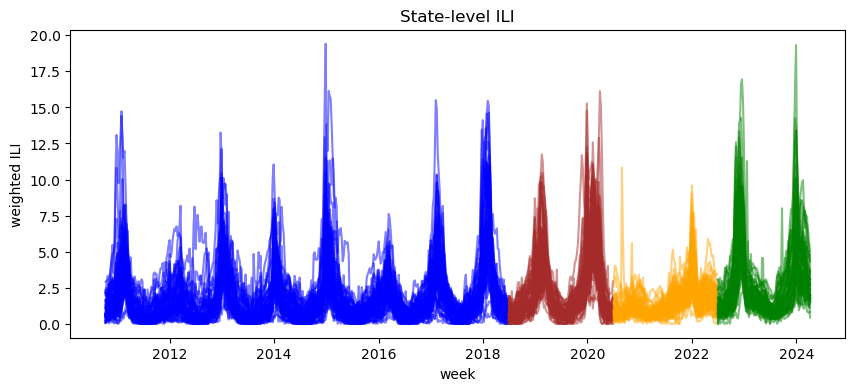

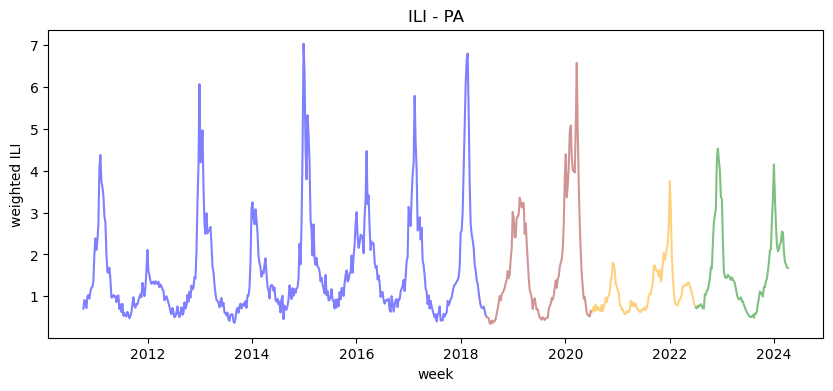

In [47]:
ILI_df = load_ili_data()

start_val_date = pd.Timestamp('2018-06-28') 
start_covid_date = pd.Timestamp('2020-06-28') 
start_test_date = pd.Timestamp('2022-07-01') 

train_ind = np.where(ILI_df.index<start_val_date)[0]
val_ind = np.where((ILI_df.index>=start_val_date) & (ILI_df.index<start_covid_date))[0]
covid_ind = np.where((ILI_df.index>=start_covid_date) & (ILI_df.index<start_test_date))[0]
test_ind = np.where(ILI_df.index>=start_test_date)[0]

plt.figure(figsize=(10,4))
plt.plot(ILI_df.index[train_ind],ILI_df.iloc[train_ind],color='blue',alpha=0.5) 
plt.plot(ILI_df.index[val_ind],ILI_df.iloc[val_ind],color='brown',alpha=0.5) 
plt.plot(ILI_df.index[covid_ind],ILI_df.iloc[covid_ind],color='orange',alpha=0.5) 
plt.plot(ILI_df.index[test_ind],ILI_df.iloc[test_ind],color='green',alpha=0.5) 
plt.ylabel('weighted ILI') 
plt.xlabel('week') 
plt.title('State-level ILI')
plt.show()

states = ILI_df.columns
state = 'PA'
state_ind = np.where(states==state)[0]

plt.figure(figsize=(10,4))
plt.plot(ILI_df.index[train_ind],ILI_df.iloc[train_ind,state_ind],color='blue',alpha=0.5) 
plt.plot(ILI_df.index[val_ind],ILI_df.iloc[val_ind,state_ind],color='brown',alpha=0.5) 
plt.plot(ILI_df.index[covid_ind],ILI_df.iloc[covid_ind,state_ind],color='orange',alpha=0.5) 
plt.plot(ILI_df.index[test_ind],ILI_df.iloc[test_ind,state_ind],color='green',alpha=0.5) 
plt.ylabel('weighted ILI') 
plt.xlabel('week') 
plt.title('ILI - {}'.format(state))
plt.show()

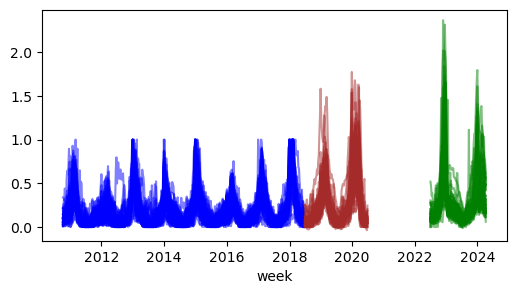

403
93


In [48]:
train_ili = ILI_df.iloc[train_ind]
val_ili = ILI_df.iloc[val_ind]
test_ili = ILI_df.iloc[test_ind]

train_dates = ILI_df.index[train_ind]
val_dates = ILI_df.index[val_ind]
test_dates = ILI_df.index[test_ind]

# scaler = MinMaxScaler() #FunctionTransformer(lambda x: x) 
# scaler.fit(train_ili)
# train_data = scaler.transform(train_ili)
# test_data = scaler.transform(test_ili)

ili_scalers = []
train_data = np.zeros(train_ili.shape)
val_data = np.zeros(val_ili.shape)
test_data = np.zeros(test_ili.shape)
for i in range(train_ili.shape[1]):
    scaler = MinMaxScaler() #FunctionTransformer(lambda x: x)  #
    scaler.fit(np.expand_dims(train_ili.iloc[:,i],-1))
    train_data[:,i] = scaler.transform(np.expand_dims(train_ili.iloc[:,i],-1)).squeeze()
    val_data[:,i] = scaler.transform(np.expand_dims(val_ili.iloc[:,i],-1)).squeeze()
    test_data[:,i] = scaler.transform(np.expand_dims(test_ili.iloc[:,i],-1)).squeeze()
    ili_scalers.append(scaler)

plt.figure(figsize=(6,3))
plt.plot(train_dates,train_data,color='blue',alpha=0.5) 
plt.plot(val_dates,val_data,color='brown',alpha=0.5) 
plt.plot(test_dates,test_data,color='green',alpha=0.5) 
plt.xlabel('week') 
plt.show()

print(len(train_data))
print(len(test_data))

In [49]:
cor_states_ind = np.where(train_ili.corr()[state]>0.85)[0]
states[cor_states_ind]

Index(['CO', 'IN', 'KS', 'MA', 'MN', 'NY', 'NC', 'OH', 'PA', 'VA', 'WV', 'US'], dtype='object')

In [50]:
def get_data_loader(ili_data,  input_length, output_length, weeks_ahead, batch_size,
                    shuffle=True, drop_last=True):
    
    SOS = np.float32(-2) #0
    # EOS = np.float32(2) #0

    ix = range(len(ili_data) - input_length - output_length - weeks_ahead + 2)
    inputs = []
    targets = []

    for i in ix:
        # input_sequence = ili_data[i:i+input_length,state_ind]
        input_sequence = ili_data[i:i+input_length,cor_states_ind]
        # input_sequence = ili_data[i:i+input_length,:]
        target_sequence = ili_data[i+input_length+weeks_ahead-1:i+input_length+output_length+weeks_ahead-1,state_ind]
        output_dim = target_sequence.shape[1]
        SOS_col = np.transpose(np.array([[SOS] for _ in range(output_dim)]))
        target_sequence = np.vstack((SOS_col,target_sequence))
        inputs.append(torch.from_numpy(input_sequence.astype(np.float32)))
        targets.append(torch.from_numpy(target_sequence.astype(np.float32)))

    # Convert lists to tensors
    inputs = torch.stack(inputs)
    targets = torch.stack(targets)

    # Create dataset and dataloader
    dataset = TensorDataset(inputs, targets)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)
    return (data_loader)

In [53]:
def validate_model(model, validation_loader, device):
    model.eval()  # Set the model to evaluation mode
    validation_loss = 0
    with torch.no_grad():  # No gradients needed for validation, reduces memory and computation
        for input, target in validation_loader:
            input, target = input.to(device), target.to(device)
            tgt_input = target[:, :-1] 
            tgt_output = target[:, 1:]
            output = model(input, tgt_input) 
            loss = sum(quantile_loss(q, tgt_output.reshape(-1), output[:,:,i].view(-1))
                        for i, q in enumerate(quantiles))    
            # loss = wis_loss(quantiles, tgt_output, output)
            validation_loss += loss.item() * input.size(0)

    model.train()
    validation_loss /= len(validation_loader.dataset)
    return validation_loss

In [54]:
def run_training_loop(num_epochs, optimizer, model, min_loss, 
                      training_loss, validation_loss, training_loader, validation_loader):

    best_model = copy.deepcopy(model) 
    cur_epoch = len(training_loss)
    for epoch in range(cur_epoch,cur_epoch+num_epochs):

        avg_train_loss = 0
        for input, target in training_loader:
            input, target = input.to(device), target.to(device)
            tgt_input = target[:, :-1] 
            tgt_output = target[:, 1:] 
            output = model(input, tgt_input) 
            output = output.squeeze(-1) #output dimension is 1
            optimizer.zero_grad()   
            loss = sum(quantile_loss(q, tgt_output.reshape(-1), output[:,:,i].view(-1))
                            for i, q in enumerate(quantiles))   
            # loss = sum(wis_loss(quantiles, tgt_output[:,:,i], output[:,:,:,i])
            #                     for i in range(output.shape[3])) 
            loss.backward()
            optimizer.step()
            avg_train_loss += loss.item() * input.size(0)
        avg_train_loss /= len(training_loader.dataset)
        training_loss.append(avg_train_loss) 

        avg_val_loss = validate_model(model, validation_loader, device)
        validation_loss.append(avg_val_loss) 
        if avg_val_loss < min_loss:
            best_model = copy.deepcopy(model) 
            min_loss = avg_val_loss
        print(f'epoch {epoch}: train - {round(avg_train_loss, 4)}, ' f'val: - {round(avg_val_loss, 4)}')

    print(min_loss)
    return (best_model, optimizer, min_loss, training_loss, validation_loss)

12
1


c:\Users\ry2460\anaconda3\envs\timeseries_forecasting\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 0: train - 1.2233, val: - 1.1128
epoch 1: train - 0.9318, val: - 0.8041
epoch 2: train - 0.6884, val: - 0.5385
epoch 3: train - 0.628, val: - 0.7109
epoch 4: train - 0.575, val: - 0.4249
epoch 5: train - 0.5217, val: - 0.4751
epoch 6: train - 0.513, val: - 0.5436
epoch 7: train - 0.4669, val: - 0.3374
epoch 8: train - 0.4362, val: - 0.611
epoch 9: train - 0.4248, val: - 0.4489
epoch 10: train - 0.4277, val: - 0.3931
epoch 11: train - 0.3927, val: - 0.5453
epoch 12: train - 0.4137, val: - 0.4443
epoch 13: train - 0.3957, val: - 0.3802
epoch 14: train - 0.4113, val: - 0.3226
epoch 15: train - 0.4294, val: - 0.4147
epoch 16: train - 0.3772, val: - 0.3391
epoch 17: train - 0.3717, val: - 0.4431
epoch 18: train - 0.3745, val: - 0.3344
epoch 19: train - 0.3406, val: - 0.432
epoch 20: train - 0.3669, val: - 0.4482
epoch 21: train - 0.3539, val: - 0.3958
epoch 22: train - 0.3678, val: - 0.3396
epoch 23: train - 0.3461, val: - 0.3406
epoch 24: train - 0.3374, val: - 0.3559
epoch 25: train

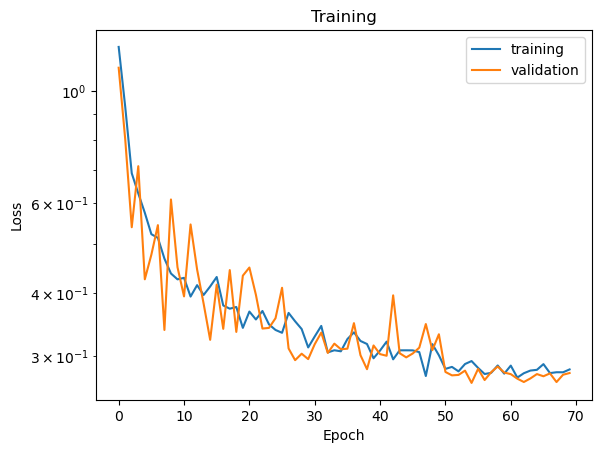

In [55]:
training_loader   = get_data_loader(train_data, input_length, output_length, weeks_ahead, batch_size)
validation_loader   = get_data_loader(val_data, input_length, output_length, weeks_ahead, batch_size)

input_dim = training_loader.dataset[0][0].shape[1]
output_dim = training_loader.dataset[0][1].shape[1]
print(input_dim)
print(output_dim)

random.seed(1) 
torch.manual_seed(1)

#initializing the model
model = TransformerEncoderDecoderQRMultiVariateModel(nhead, d_model, d_hid, nlayers, 
                                                     input_length, output_length, 
                                                     input_dim, output_dim,
                                                     nquantiles, dropout)
model = model.to(device)

#training
min_loss = sys.maxsize 
training_loss = [] 
validation_loss = [] 

# Training loop
optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-3) 
(model, optimizer, min_loss, training_loss, validation_loss) = \
    run_training_loop(50, optimizer, model, min_loss, training_loss, validation_loss, training_loader, validation_loader)
optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-4) 
(model, optimizer, min_loss, training_loss, validation_loss) = \
    run_training_loop(10, optimizer, model, min_loss, training_loss, validation_loss, training_loader, validation_loader)
optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-5) 
(model, optimizer, min_loss, training_loss, validation_loss) = \
    run_training_loop(10, optimizer, model, min_loss, training_loss, validation_loss, training_loader, validation_loader)

#training progress
plot_training_progress = True
if(plot_training_progress):
    plt.figure()
    plt.title('Training') 
    plt.yscale('log') 
    plt.plot(training_loss, label = 'training') 
    plt.plot(validation_loss, label = 'validation') 
    plt.ylabel('Loss') 
    plt.xlabel('Epoch') 
    plt.legend() 
    plt.show()


In [56]:
# def get_model_pred(data, prev_pred, model, weeks_ahead):
    # data_loader = get_data_loader(data, prev_pred, input_length, output_length, 
    #                               weeks_ahead, batch_size, shuffle=False, drop_last=False)

def get_model_pred(data, model, weeks_ahead):
    data_loader = get_data_loader(data, input_length, output_length, 
                                  weeks_ahead, batch_size, shuffle=False, drop_last=False)
    pred = []
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No gradients needed for validation, reduces memory and computation
        avg_loss = 0
        for input, target in data_loader:
            input, target = input.to(device), target.to(device)
            tgt_input = target[:, :-1] 
            tgt_output = target[:, 1:] 
            output = model(input, tgt_input) 
            loss = sum(wis_loss(quantiles, tgt_output[:,:,i], output[:,:,:,i])
                                for i in range(output.shape[3])) 
            # loss = wis_loss(quantiles, tgt_output, output)       
            avg_loss += loss.item() * input.size(0)
            out = output[:,0,:].to('cpu').detach().numpy().squeeze()
            if(len(out.shape)==1):
                out = np.expand_dims(out,0) #last batch may contain only one input
            pred.append(out)
        avg_loss /= len(data_loader.dataset)
        print(avg_loss)

    pred = np.concatenate(pred, axis=0)
    return pred

In [57]:
def get_ili_data_and_pred(pred, ili, dates, weeks_ahead):
    
    scaler = ili_scalers[state_ind[0]]
    pred_ili = np.zeros(pred.shape)
    for i, q in enumerate(quantiles):
        pred_ili[:,i] = scaler.inverse_transform(np.expand_dims(pred[:,i],-1)).squeeze()
        # pred_ili[:,i,:] = np.expand_dims(scaler.inverse_transform(pred[:,i,:]),1) #if output are all states
    
    #slice ili and test_dates to same dates as pred dates
    ili_slice = ili[input_length+(weeks_ahead-1):]
    ili_slice = ili_slice[:len(pred_ili)]
    dates_slice = dates[input_length+(weeks_ahead-1):]
    dates_slice = dates_slice[:len(pred_ili)]
    return (pred_ili,ili_slice,dates_slice)

0.023021782239558256


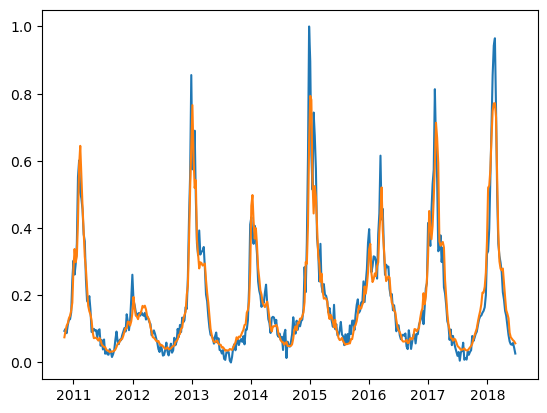

In [58]:
pred_train1 =  get_model_pred(train_data, model, weeks_ahead)
pred_train_ili1, train_ili1, train_dates1 = get_ili_data_and_pred(pred_train1, train_ili, train_dates, weeks_ahead)

q_median_ind = quantiles.index(0.5)
plt.plot(train_dates1, train_data[input_length+(weeks_ahead-1):,state_ind])
plt.plot(train_dates1, pred_train1[:,q_median_ind])

0.051546629560127684


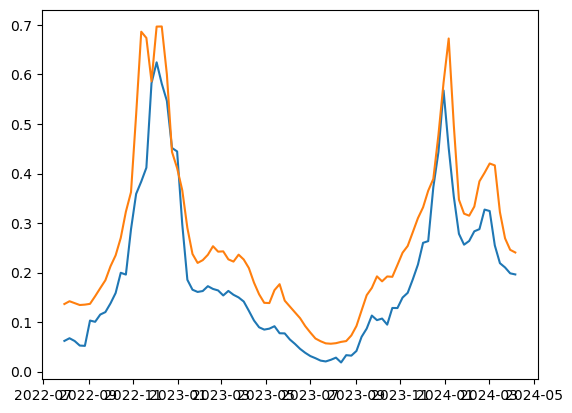

In [59]:
pred_test1 =  get_model_pred(test_data, model, weeks_ahead)
pred_test_ili1, test_ili1, test_dates1 = get_ili_data_and_pred(pred_test1, test_ili, test_dates, weeks_ahead)

q_median_ind = quantiles.index(0.5)
plt.plot(test_dates[input_length+(weeks_ahead-1):], test_data[input_length+(weeks_ahead-1):,state_ind])
plt.plot(test_dates[input_length+(weeks_ahead-1):], pred_test1[:,q_median_ind])

In [60]:
def plot_pred_test(pred_test_ili, test_ili, test_dates, weeks_ahead, state):
    
    state_ind = np.where(states==state)[0]
    wis_score_test = np.round(wis_loss(quantiles, 
                                       np.expand_dims(test_ili[state].values,-1), 
                                       np.expand_dims(pred_test_ili,1)),3)
    ##if output are all states
    # wis_score_test = np.round(wis_loss(quantiles, 
    #                                    np.expand_dims(test_ili[state].values,-1), 
    #                                    np.expand_dims(pred_test_ili[:,:,state_ind].squeeze(),1)),3)
    print(f'Weighted Interval Score - weeks_ahead={weeks_ahead} (length={len(test_ili)}): {wis_score_test}')

    q_median_ind = quantiles.index(0.5)
    lowq = 0.025
    uppq = 0.975
    q_low_ind = quantiles.index(lowq) #quantiles.index(0.25) #
    q_high_ind = quantiles.index(uppq) #quantiles.index(0.75) #
    plt.figure(figsize=(10, 4))
    plt.plot(test_dates,test_ili[state],'o--',markersize=3,label='data',color='black',alpha=0.75)
    plt.plot(test_dates,pred_test_ili[:,q_median_ind].squeeze(), label='pred median',alpha=0.75, color='green')
    plt.plot(test_dates,pred_test_ili[:,q_low_ind].squeeze(), label='pred low ({})'.format(lowq),alpha=0.75, color='blue')
    plt.plot(test_dates,pred_test_ili[:,q_high_ind].squeeze(), label='pred high ({})'.format(uppq),alpha=0.75, color='red')
    ##if output are all states
    # plt.plot(test_dates,pred_test_ili[:,q_median_ind,state_ind].squeeze(), label='pred median',alpha=0.75, color='green')
    # plt.plot(test_dates,pred_test_ili[:,q_low_ind,state_ind].squeeze(), label='pred low ({})'.format(lowq),alpha=0.75, color='blue')
    # plt.plot(test_dates,pred_test_ili[:,q_high_ind,state_ind].squeeze(), label='pred high ({})'.format(uppq),alpha=0.75, color='red')
    plt.xlabel('week')
    plt.ylabel('ILI')
    plt.title('state={}, horizon={} weeks (WIS={})'.format(state,weeks_ahead,wis_score_test))
    plt.legend(loc=0)

Weighted Interval Score - weeks_ahead=1 (length=89): 0.344


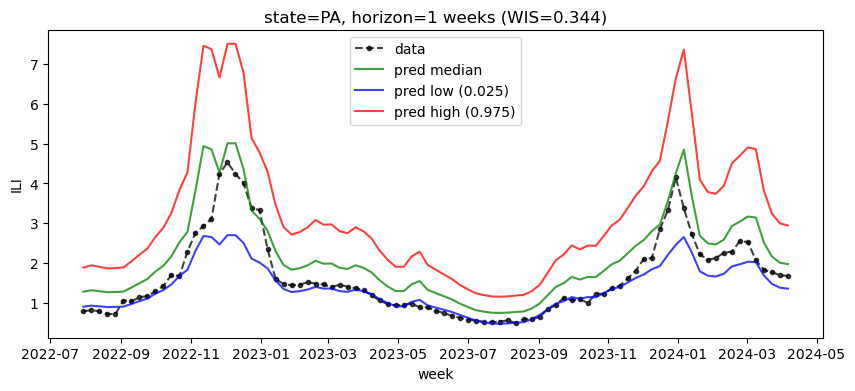

In [61]:
# state = 'TX'
plot_pred_test(pred_test_ili1, test_ili1, test_dates1, weeks_ahead, state)